In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import hvplot.xarray
 
from mlprecip_utils import *

import mlprecip_utils

import warnings

/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib

In [2]:
warnings.filterwarnings("ignore")

### Set Variables for plotting, region, etc.

In [3]:
cmap='DryWet'
clevs=np.arange(-0.8,0.9,0.1)
labels=['Positive','Neutral','Negative']
v='precip'

# SEUS
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]

# US
#lonreg=[230,310]
#latreg=[25,55]

winter=[12,1,2]
summer=[6,7,8]
sdate='1997-01-01'
#edate='2019-12-31'
edate='2015-02-28'
bins=[-100,-0.5,0.5,100]

### Read in Precip Data, Maskout Land, Subset to Region, & Calculate Anomalies

In [4]:
# Read in Precip Data
fnames='/scratch/zmanthos/GPCP/gpcp_v01r03_daily.*.nc'
ds=getPrecipData(fnames,'1996-12-15','2020-01-15')

# Read in mask file and interpolate
lmask_file='/shared/subx/hindcast/land_cover.nc'
ds_mask=xr.open_dataset(lmask_file)
ds_mask=ds_mask.interp(lat=ds['lat'],lon=ds['lon'])

# Maskout Land
ds=ds.where(ds_mask['land']==1)

# Subset to SEUS
ds_seus=ds.sel(lat=slice(lat_reg[0],lat_reg[1]),lon=slice(lon_reg[0],lon_reg[1]))

# Calculate Anomalies
ds_anoms=ds_seus.groupby('time.dayofyear')-ds_seus.groupby('time.dayofyear').mean()

ds_anoms

<xarray.Dataset>
Dimensions:    (lat: 13, lon: 15, time: 8432)
Coordinates:
  * lon        (lon) float32 269.0 270.0 271.0 272.0 ... 280.0 281.0 282.0 283.0
  * lat        (lat) float32 24.0 25.0 26.0 27.0 28.0 ... 33.0 34.0 35.0 36.0
  * time       (time) datetime64[ns] 1996-12-15 1996-12-16 ... 2020-01-15
    dayofyear  (time) int64 350 351 352 353 354 355 356 ... 9 10 11 12 13 14 15
Data variables:
    precip     (time, lat, lon) float32 dask.array<chunksize=(1, 13, 15), meta=np.ndarray>

### Main Program

Summer
============= Categorical upper tercile  ================
Upper Tercile:  0.6263165390491487
Logistic Training set accuracy score: 0.5486725663716814
Logistic Test set accuracy score: 0.5659163987138264
CHECK NN:  1177 66
NN Training set accuracy score: 0.6942880135913674
NN Test set accuracy score: 0.6302250841231208
============= Categorical lower tercile ===============
Lower Tercile:  -2.115304524898529
Logistic Training set accuracy score: 0.5591311343523733
Logistic Test set accuracy score: 0.5819935691318328
CHECK NN:  1127 116
NN Training set accuracy score: 0.689460981352523
NN Test set accuracy score: 0.6688102901556867


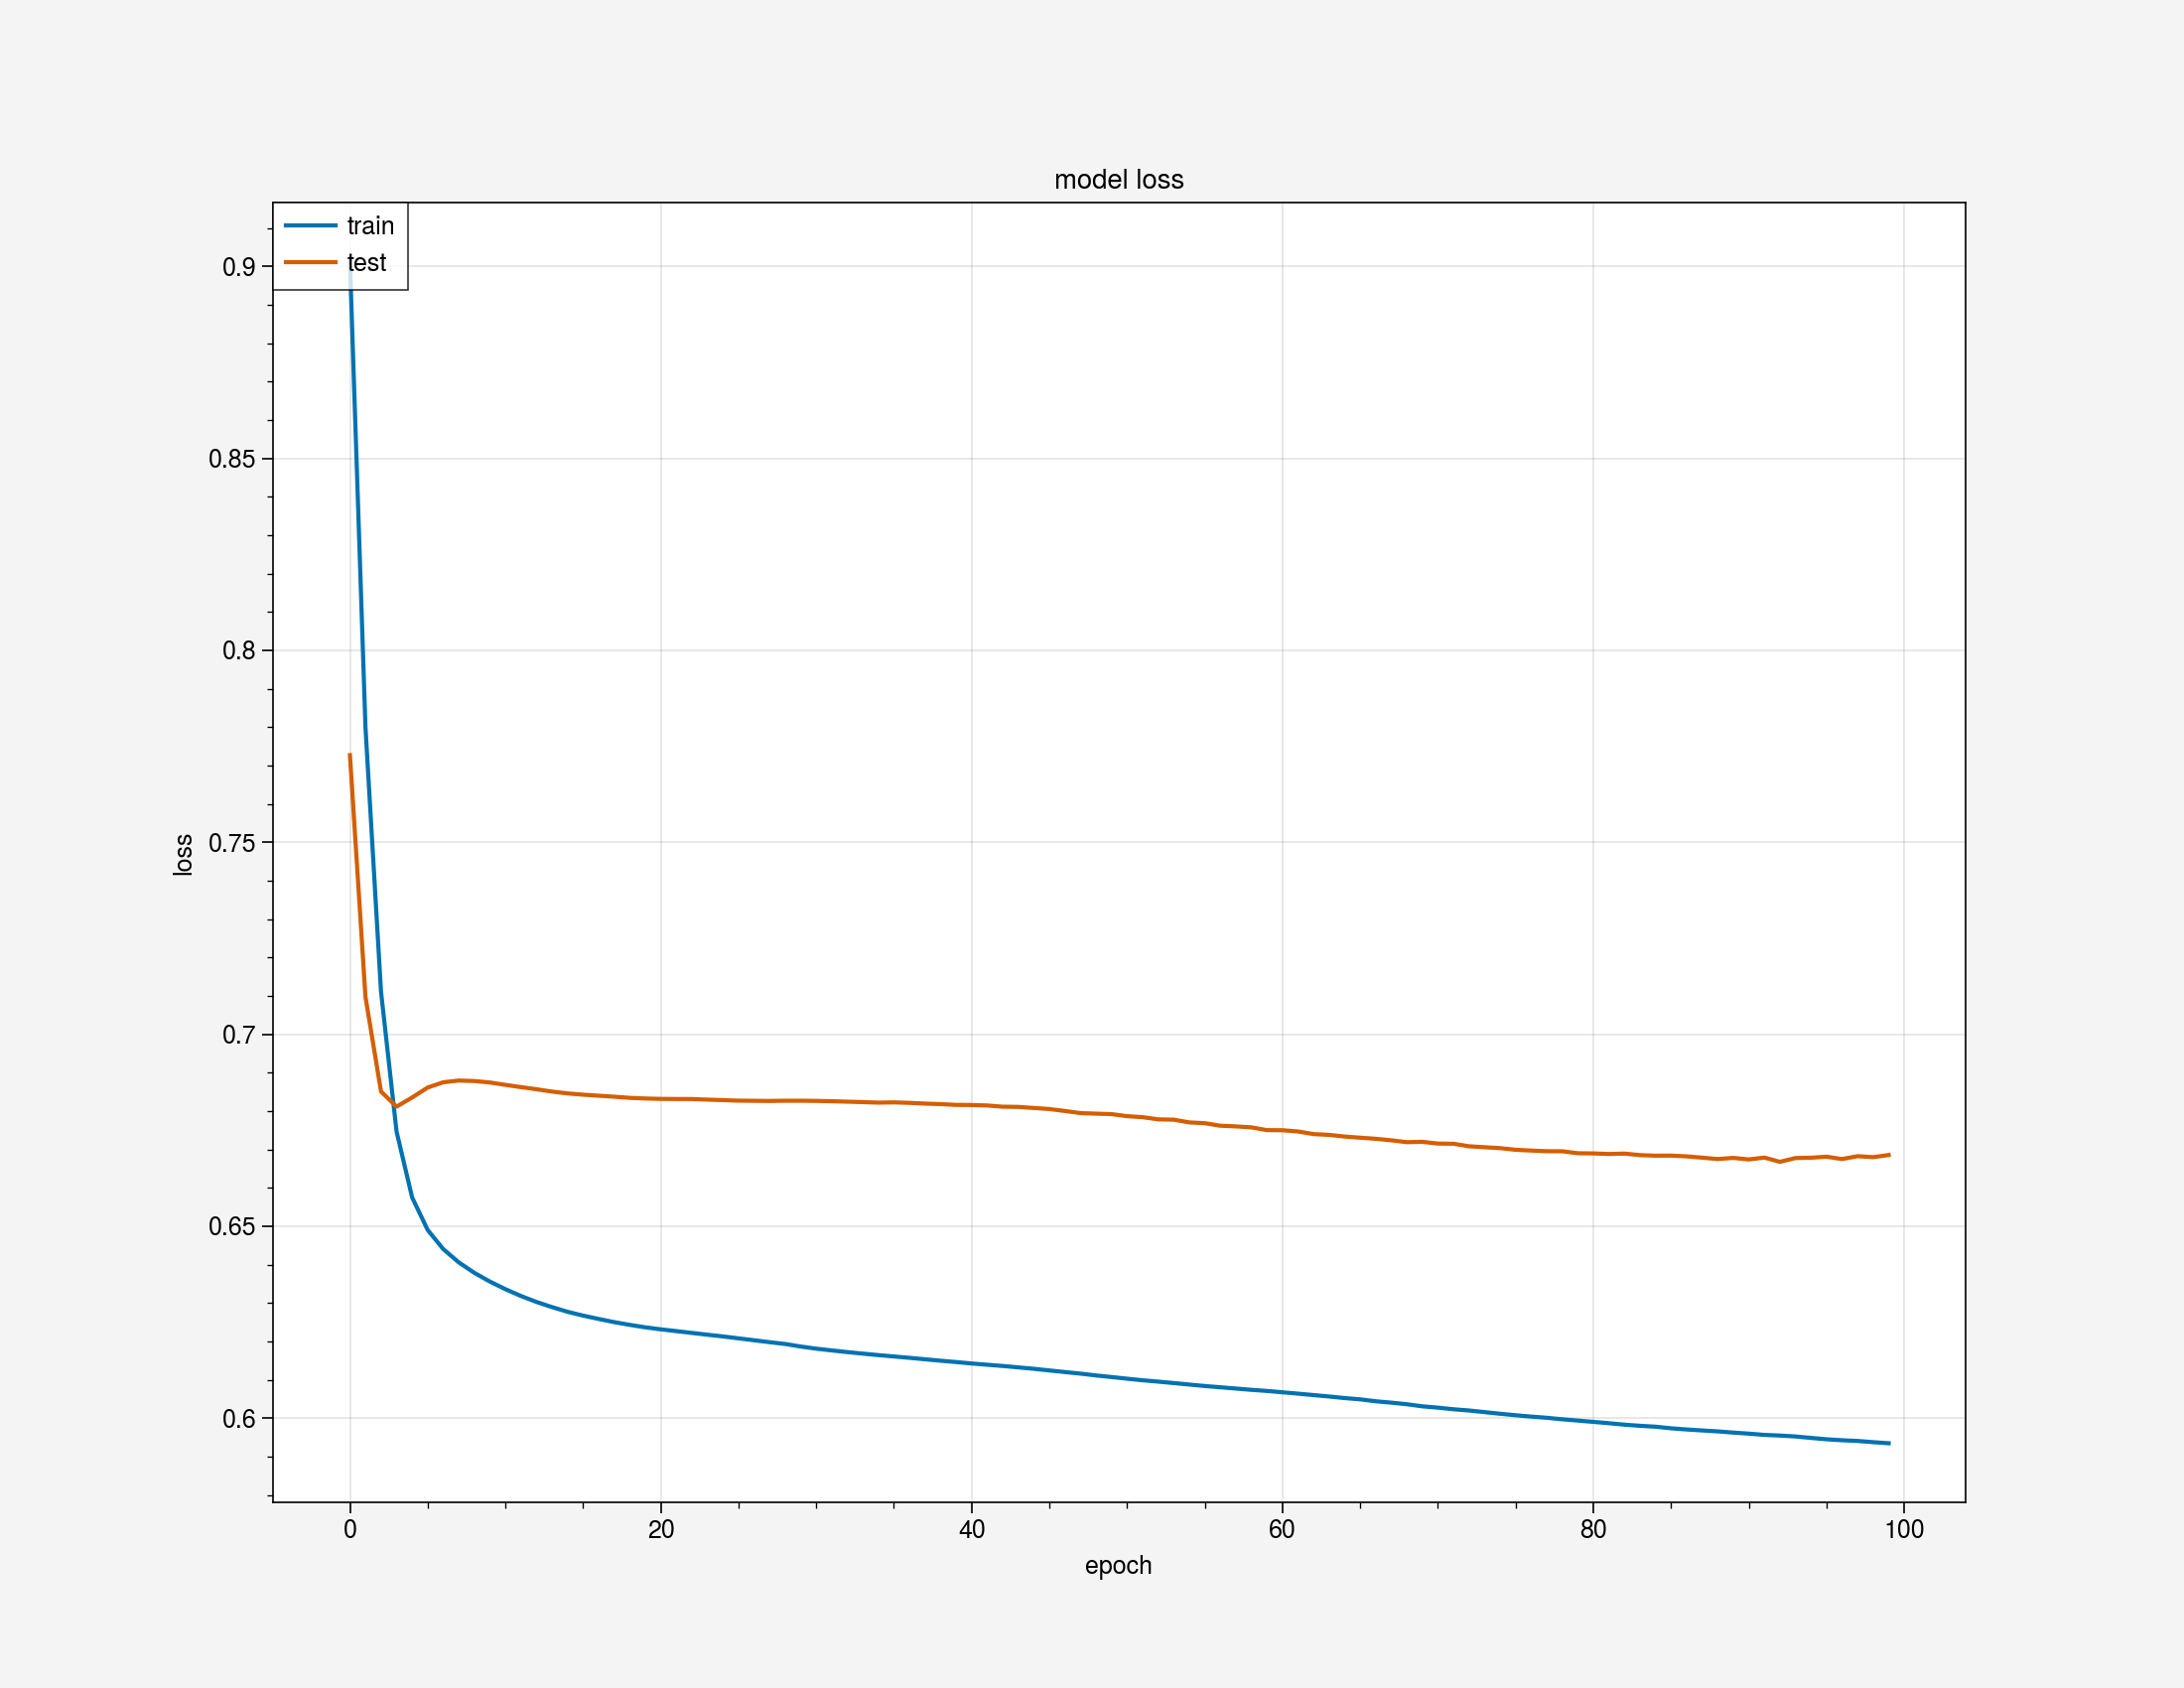

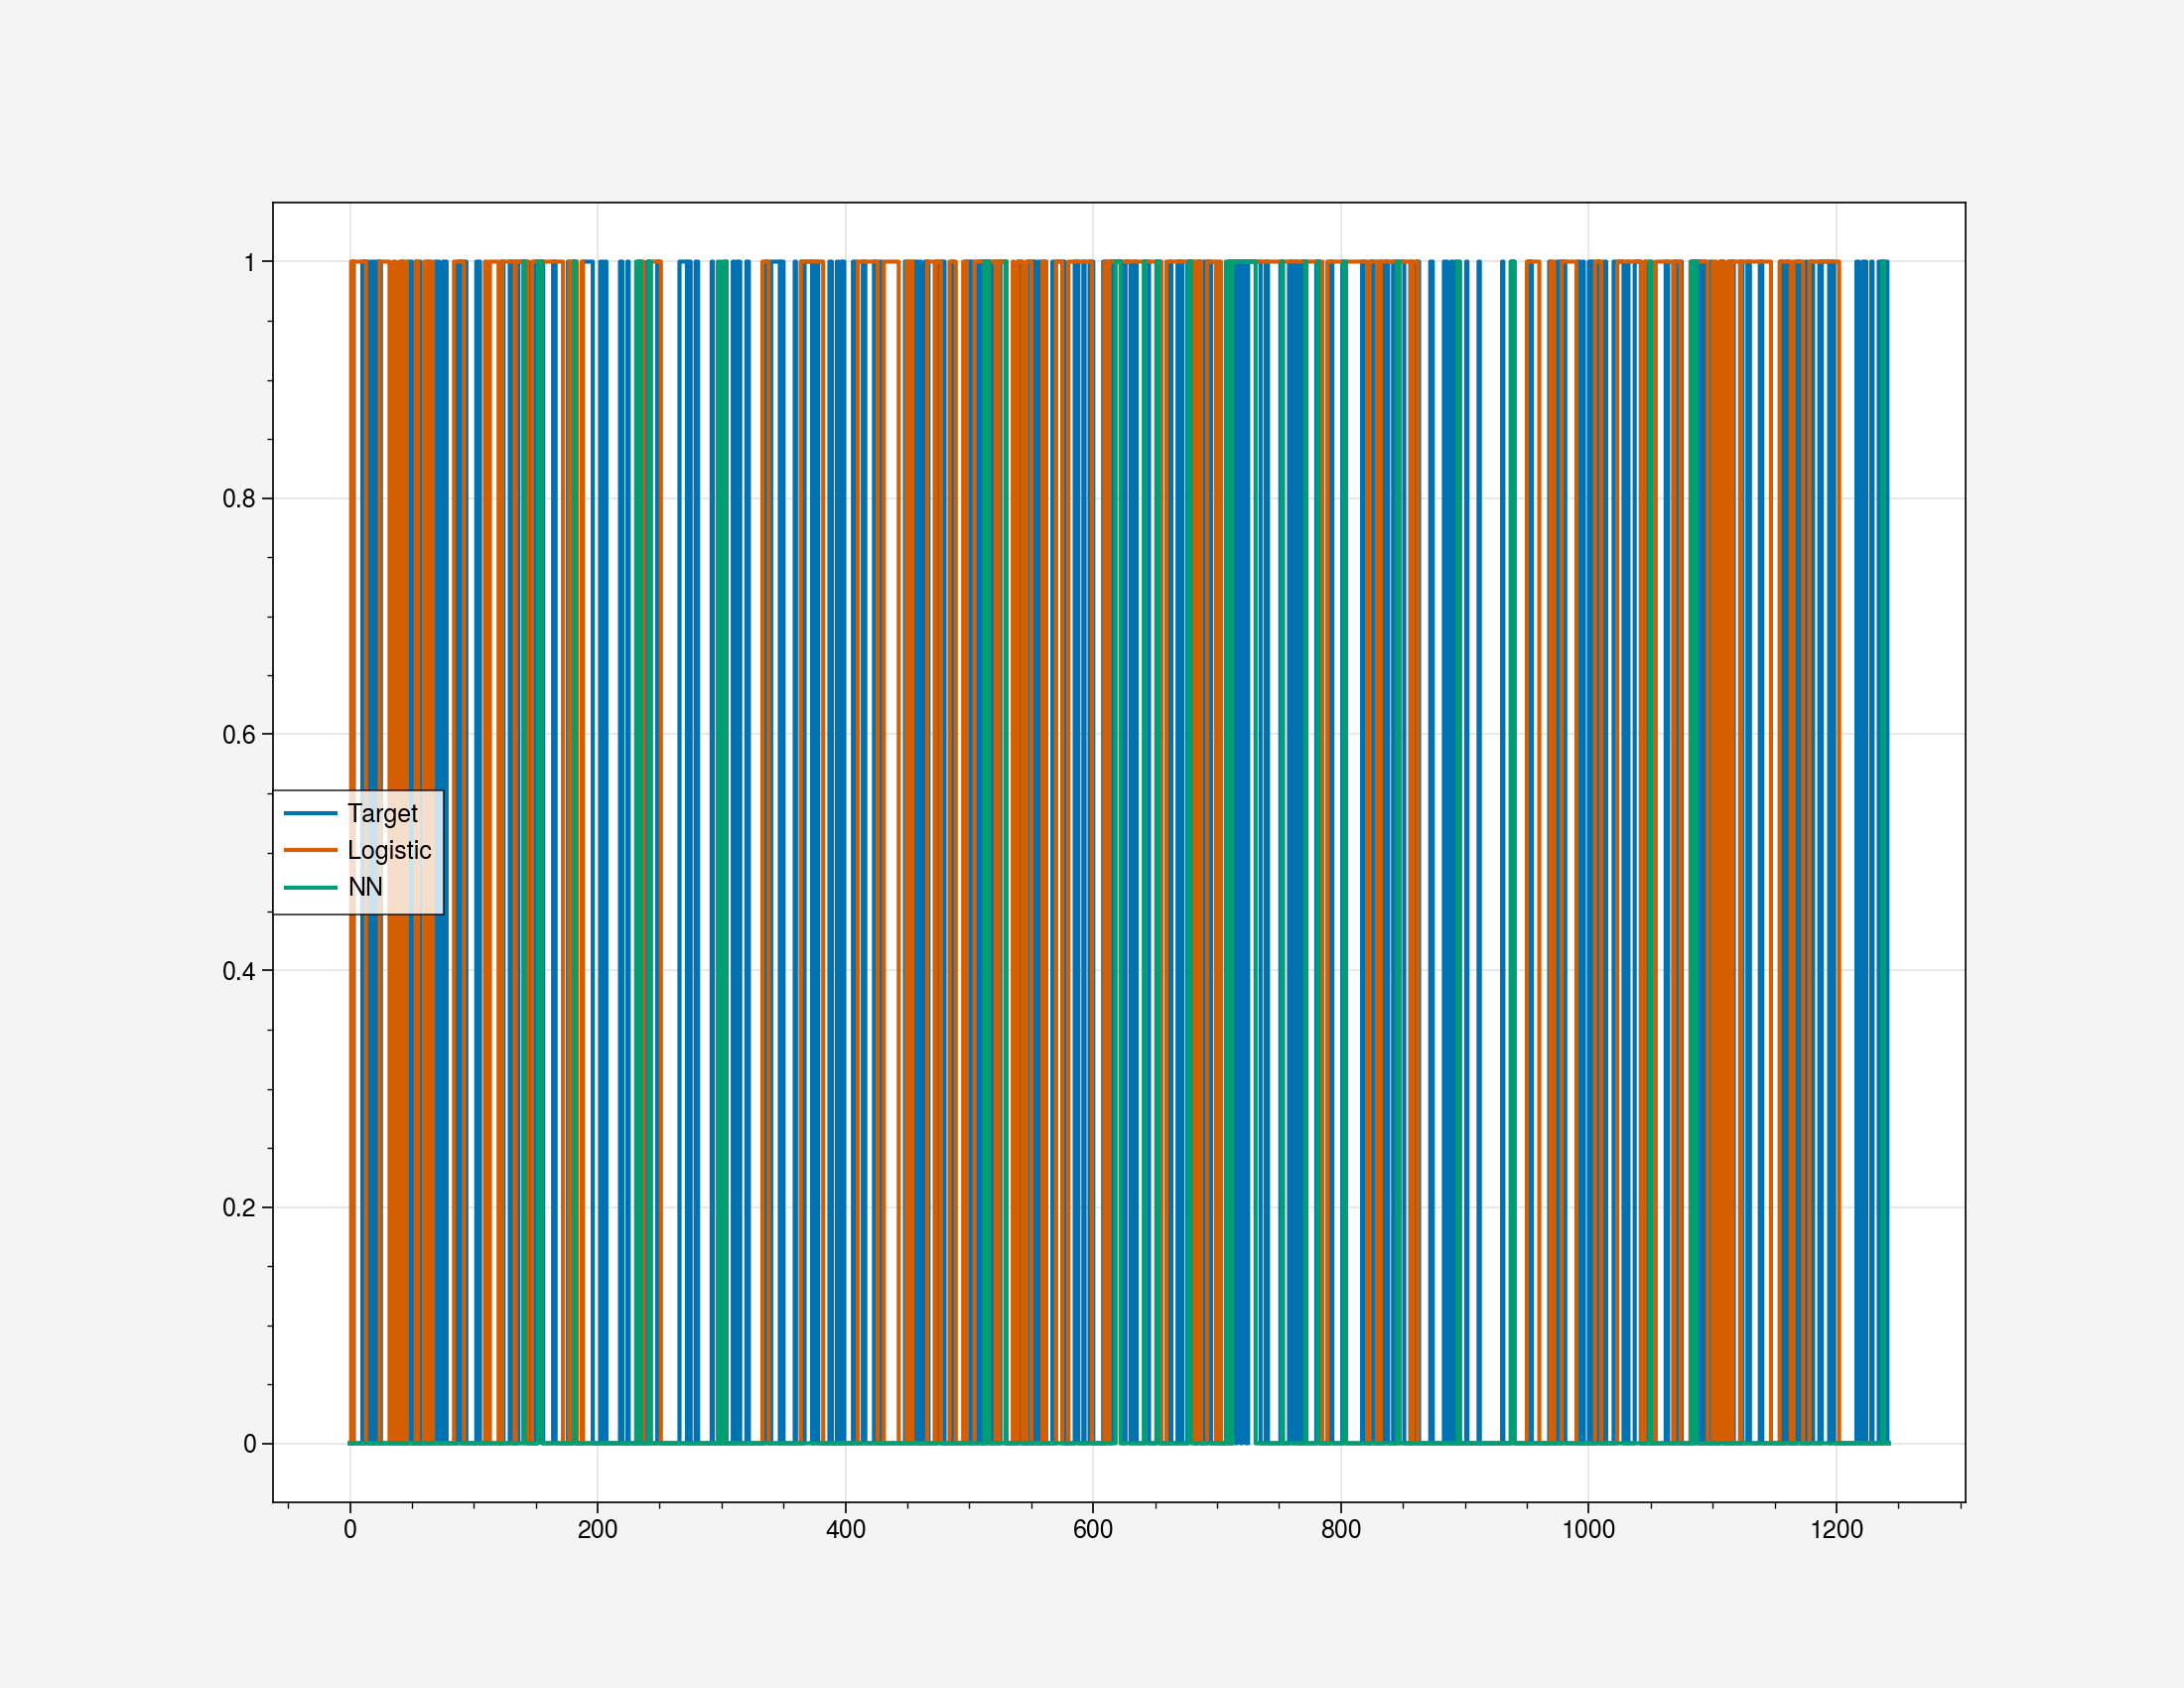

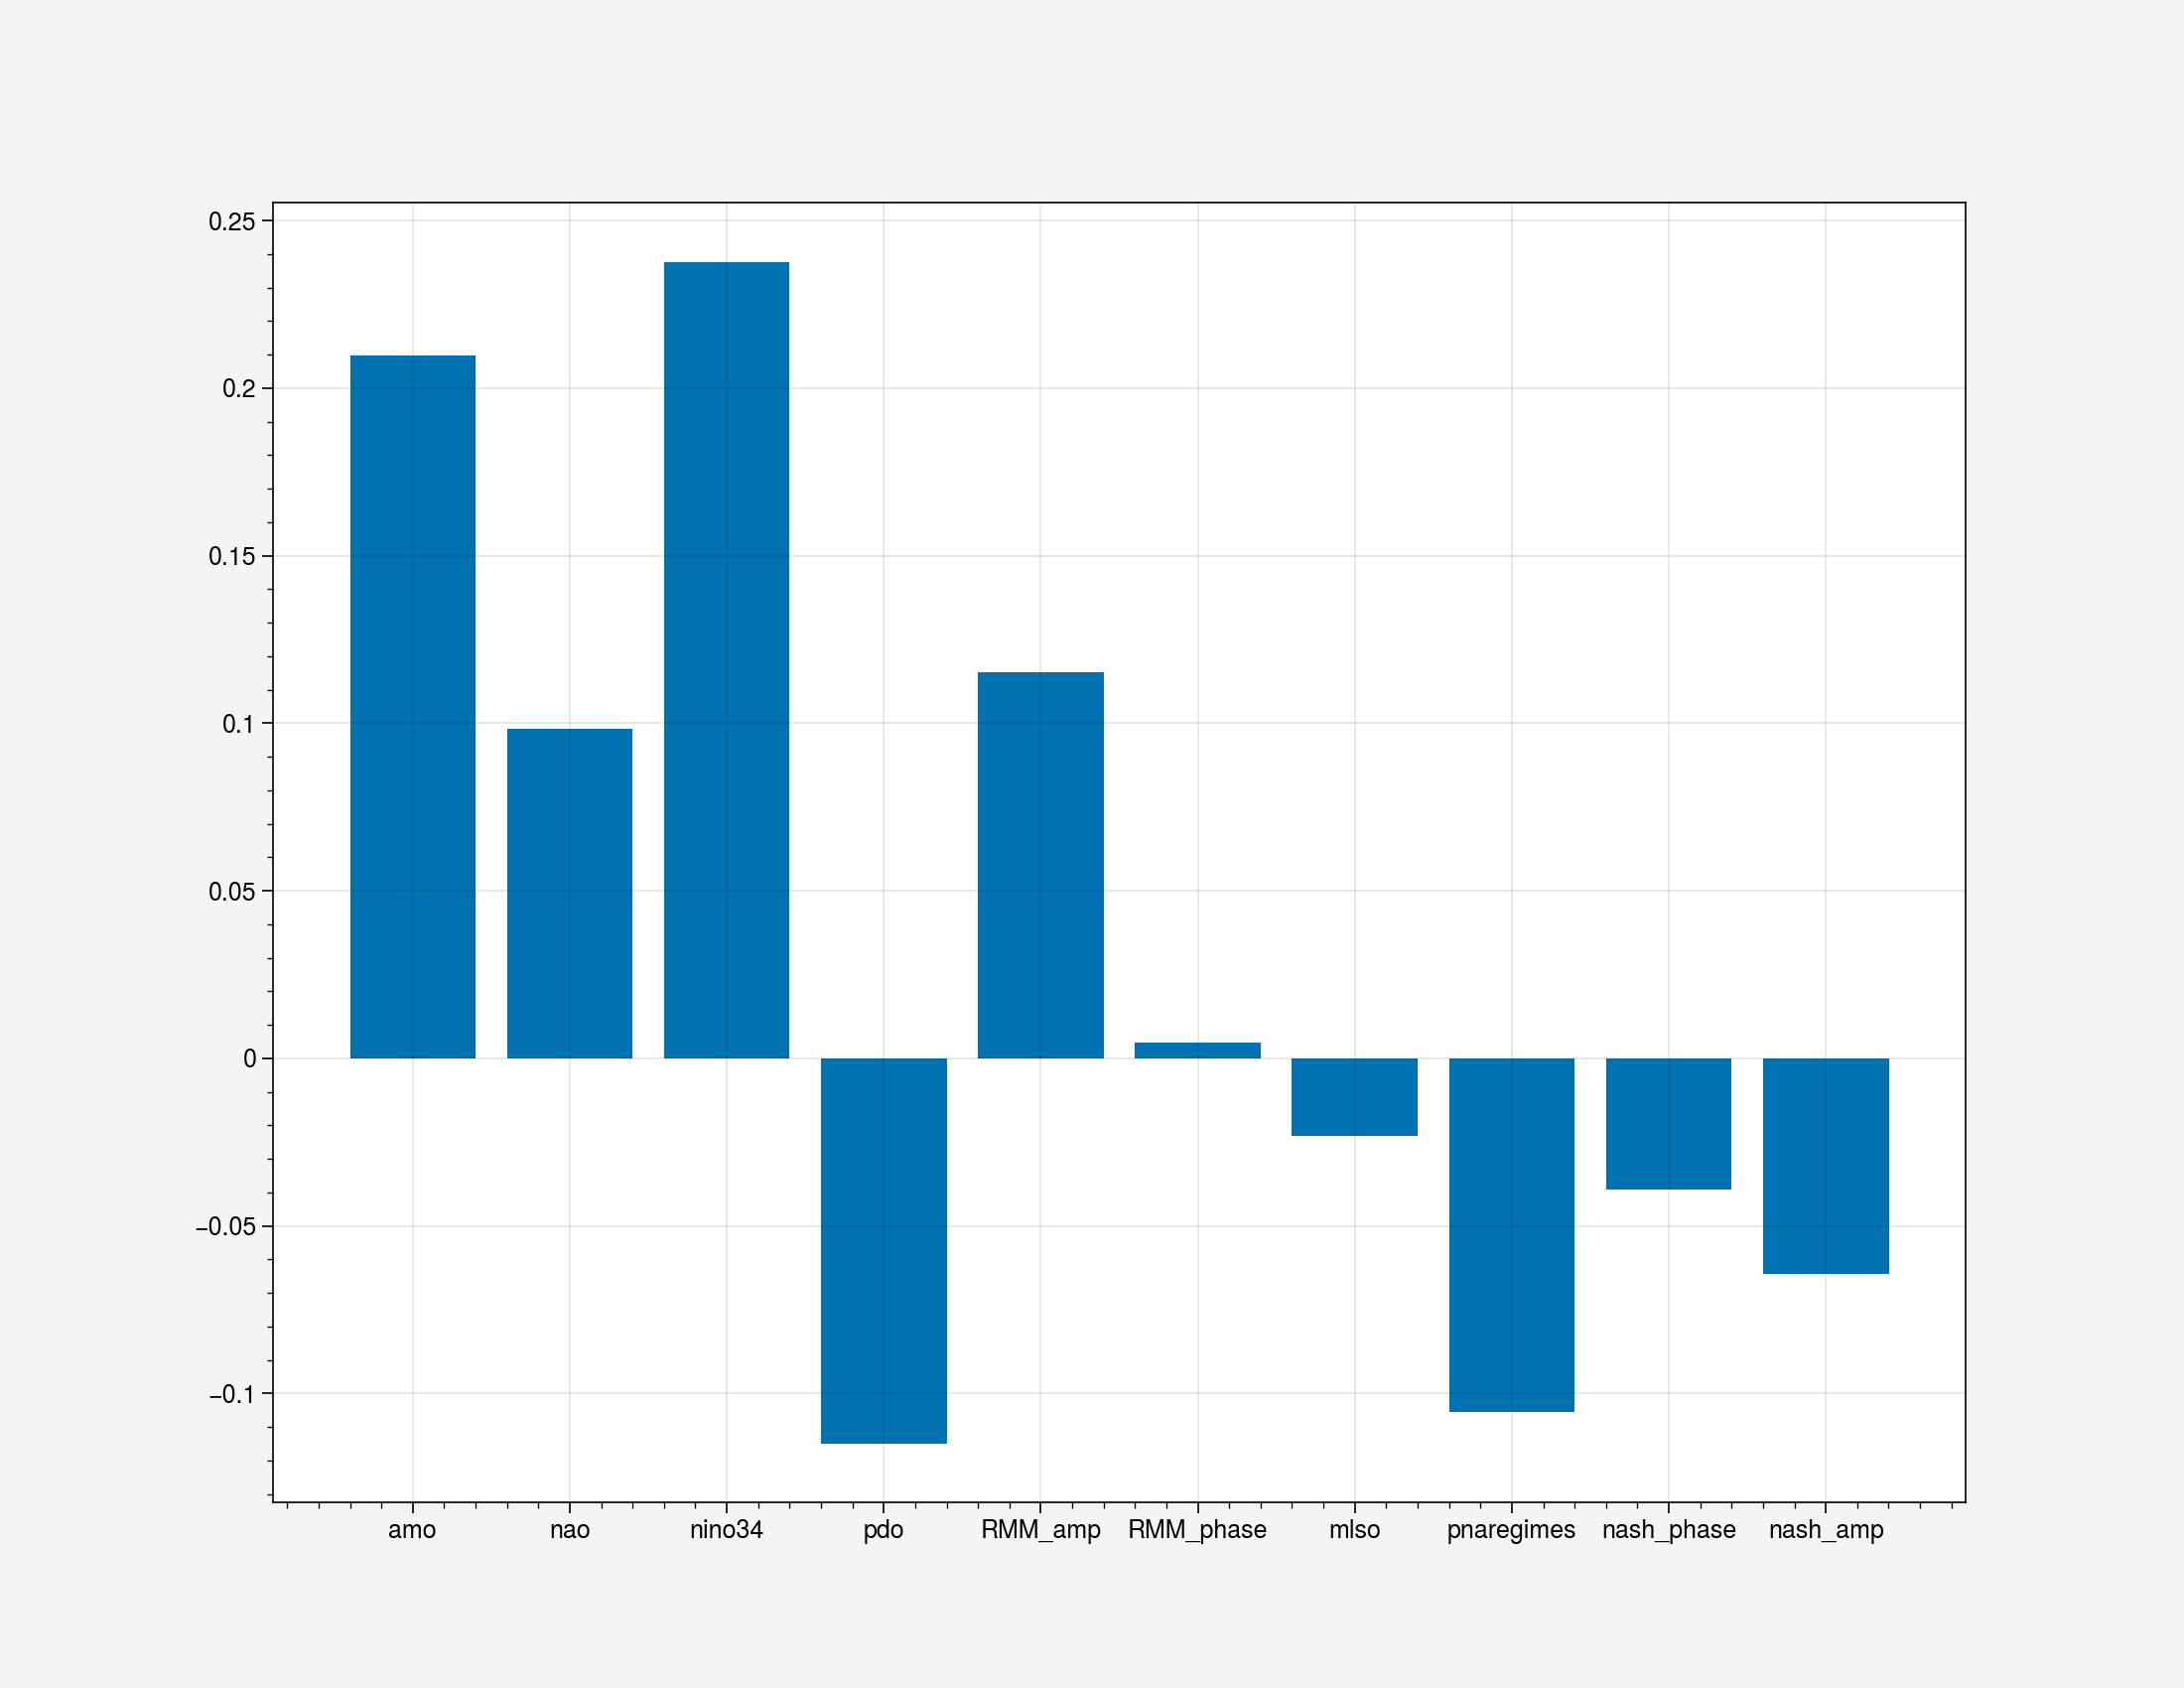

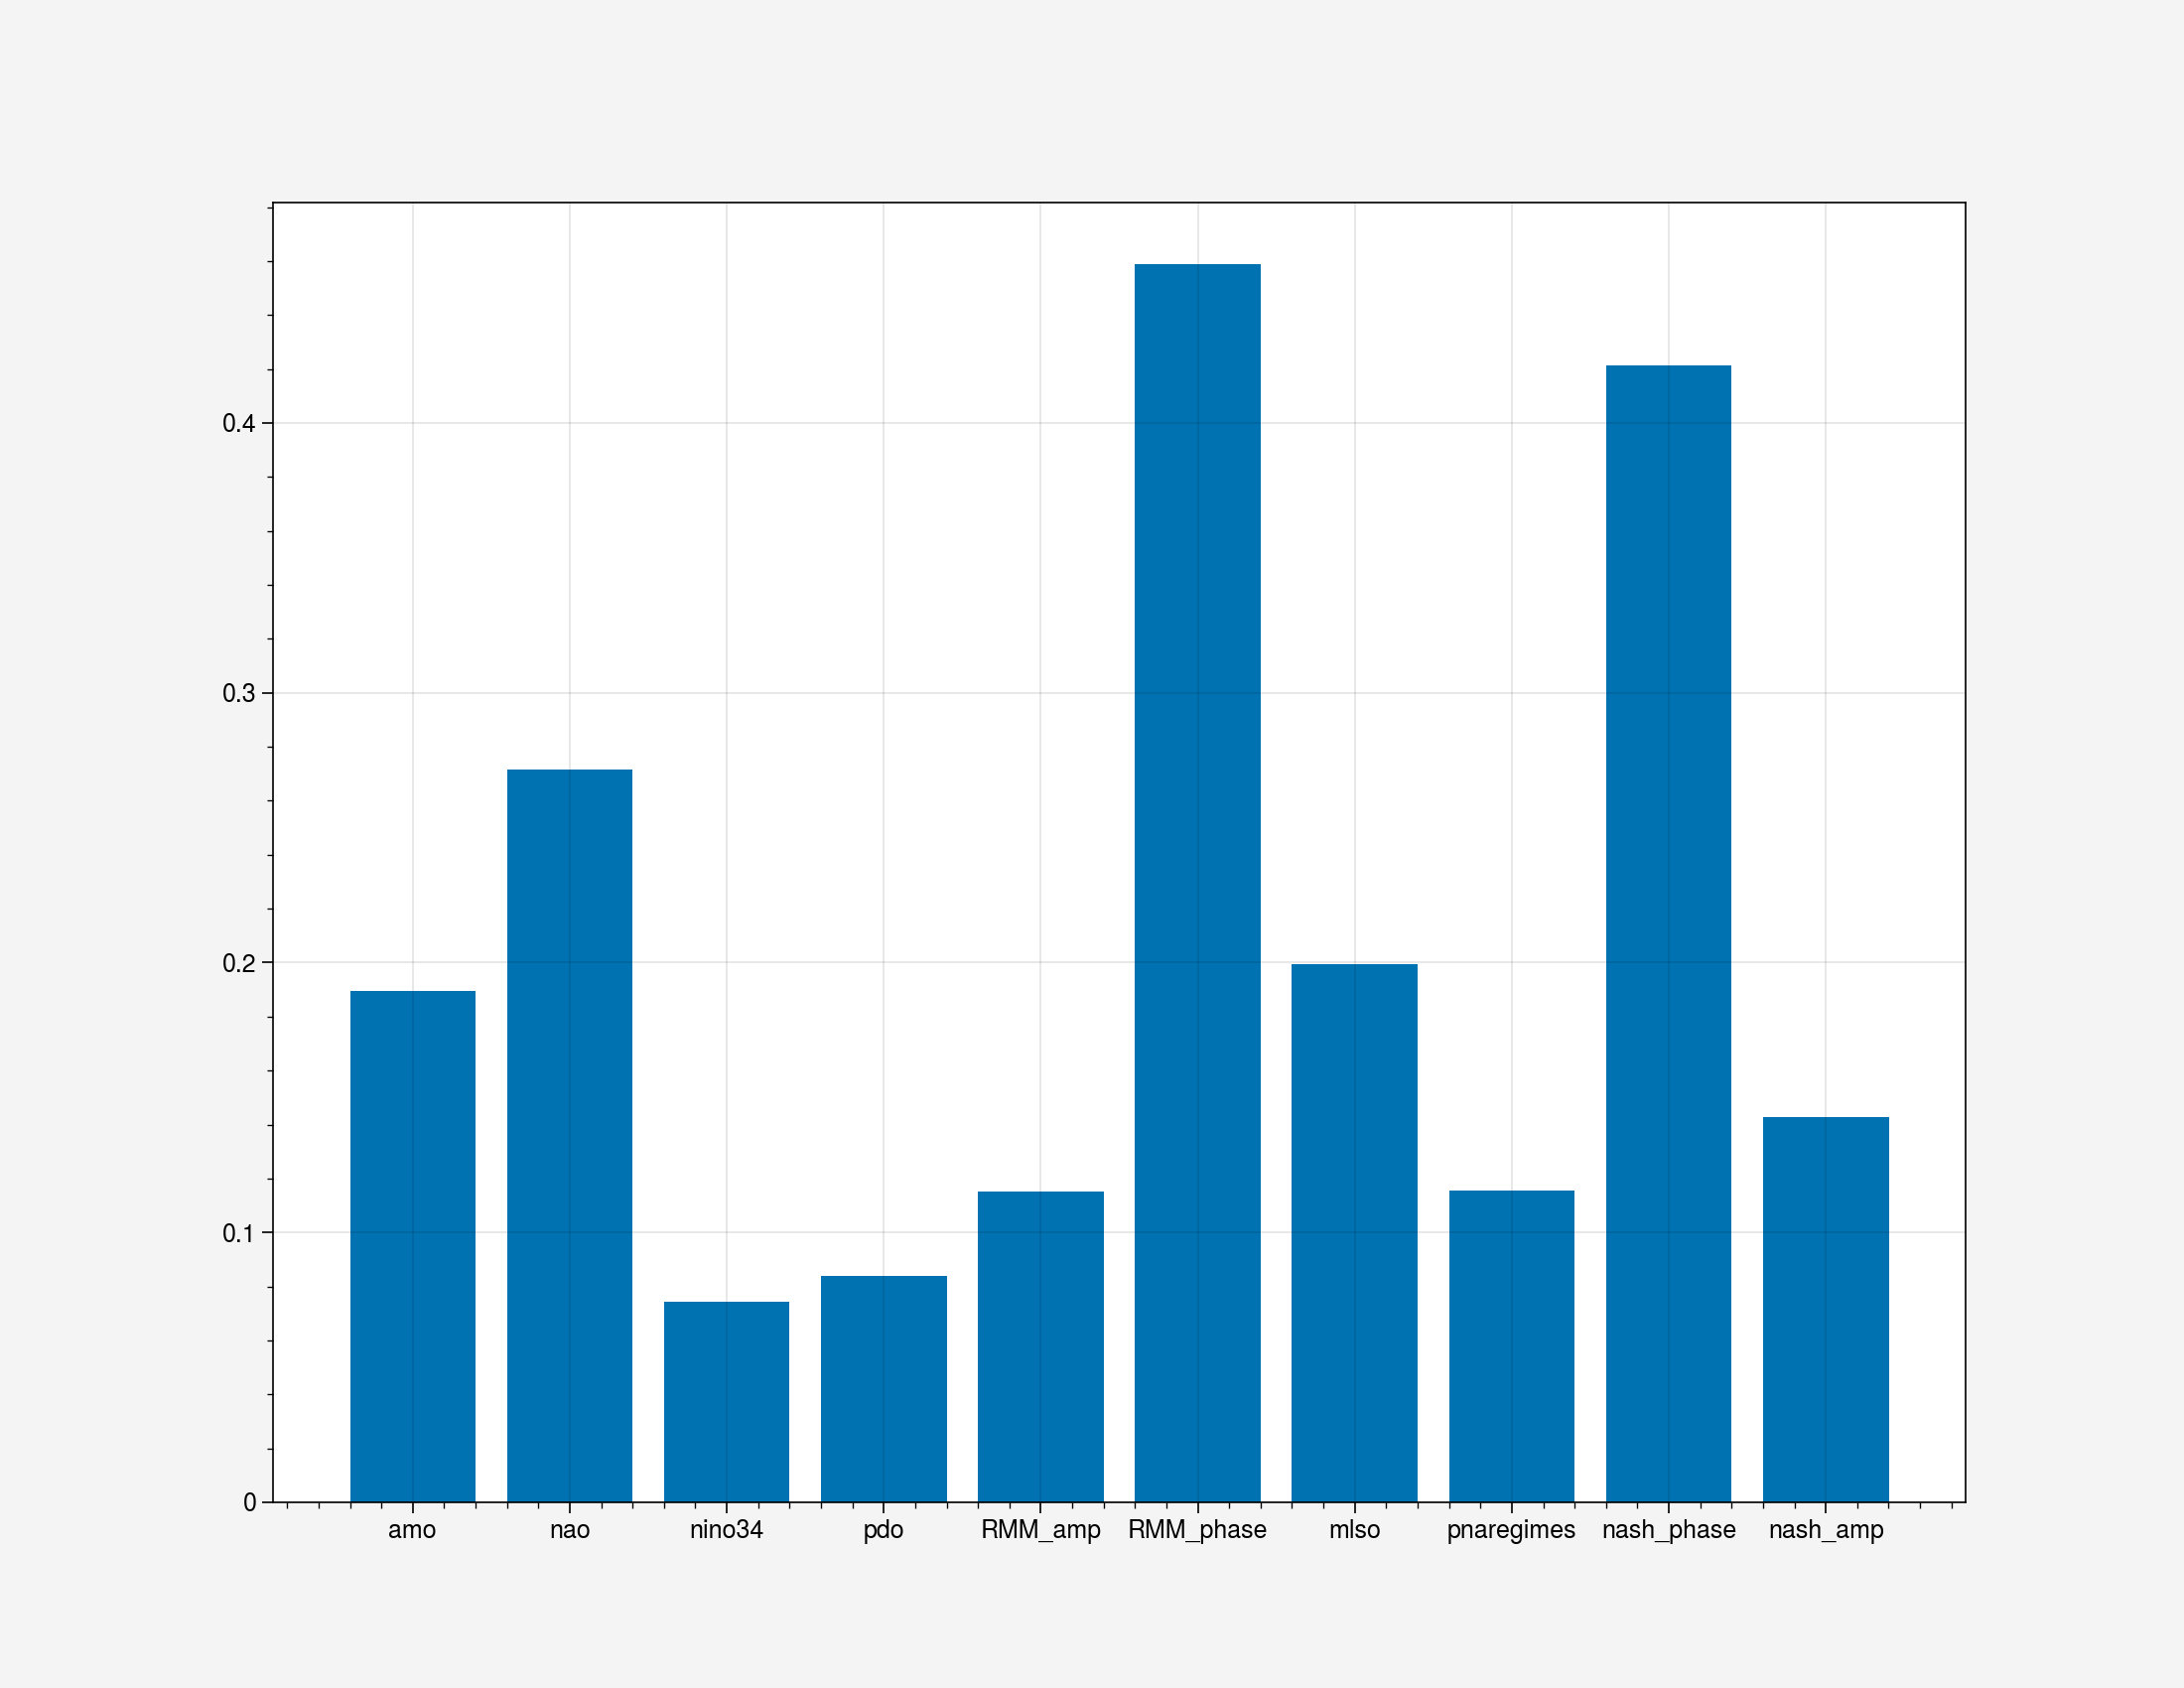

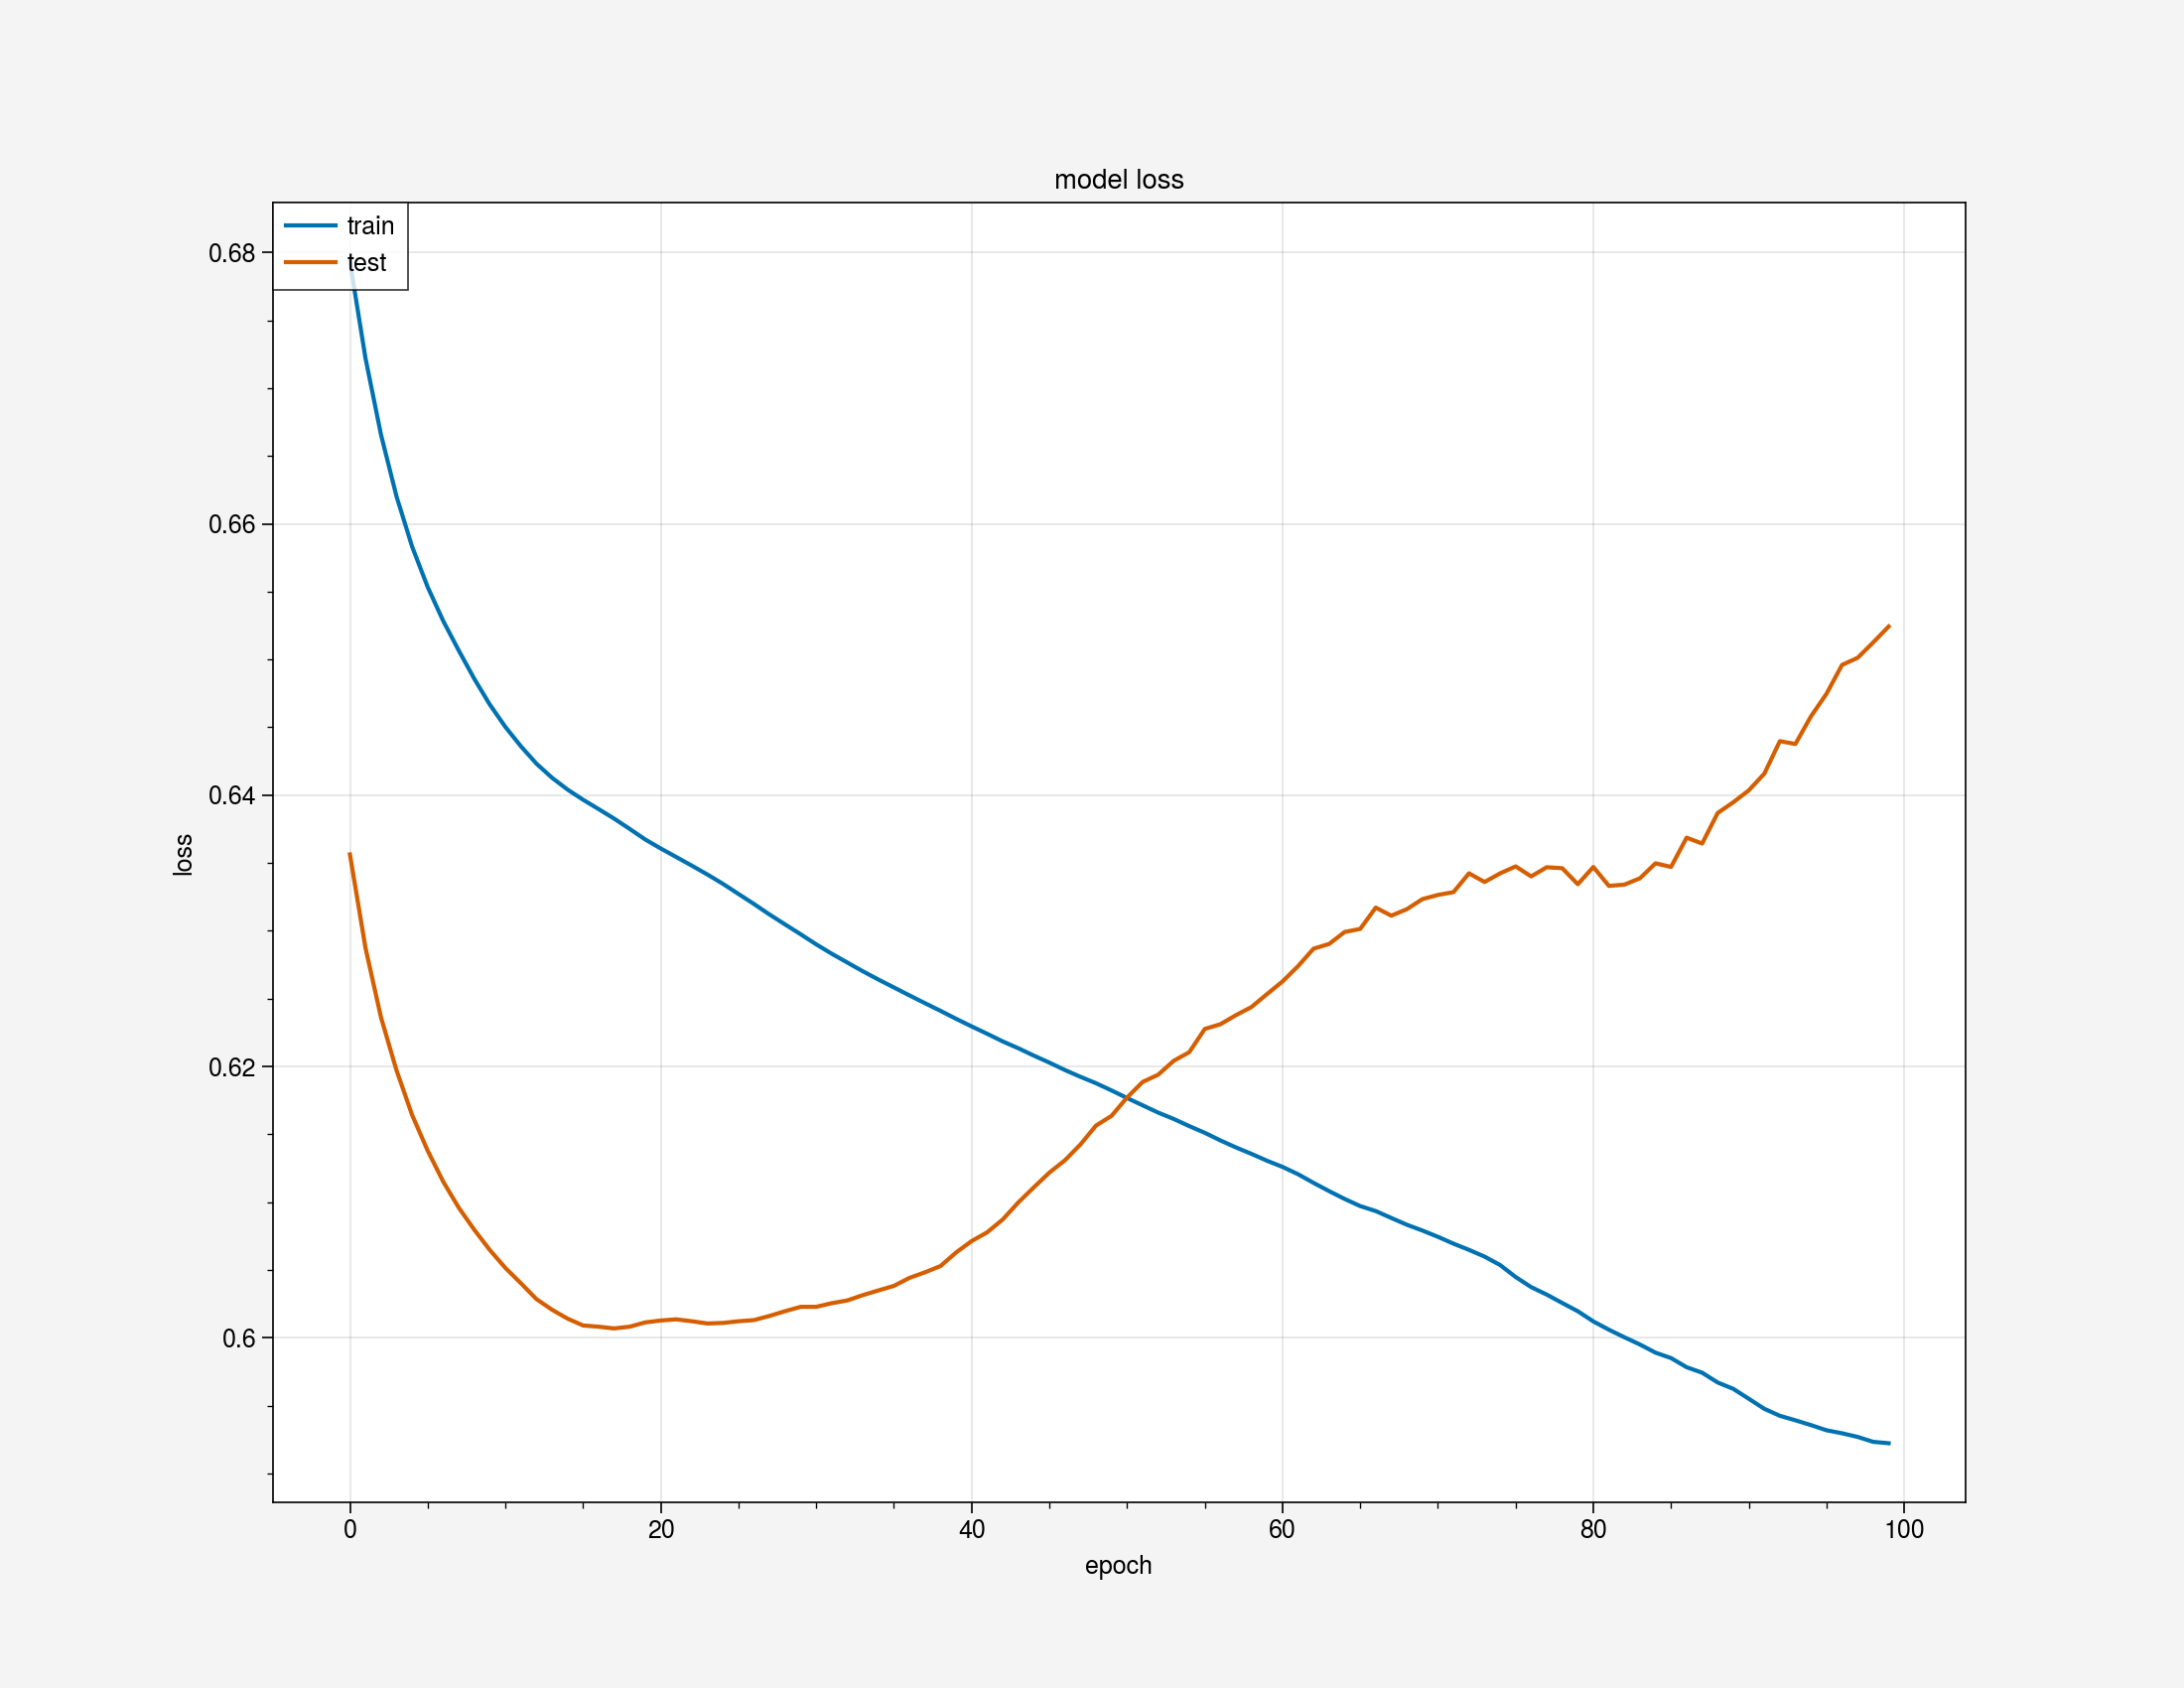

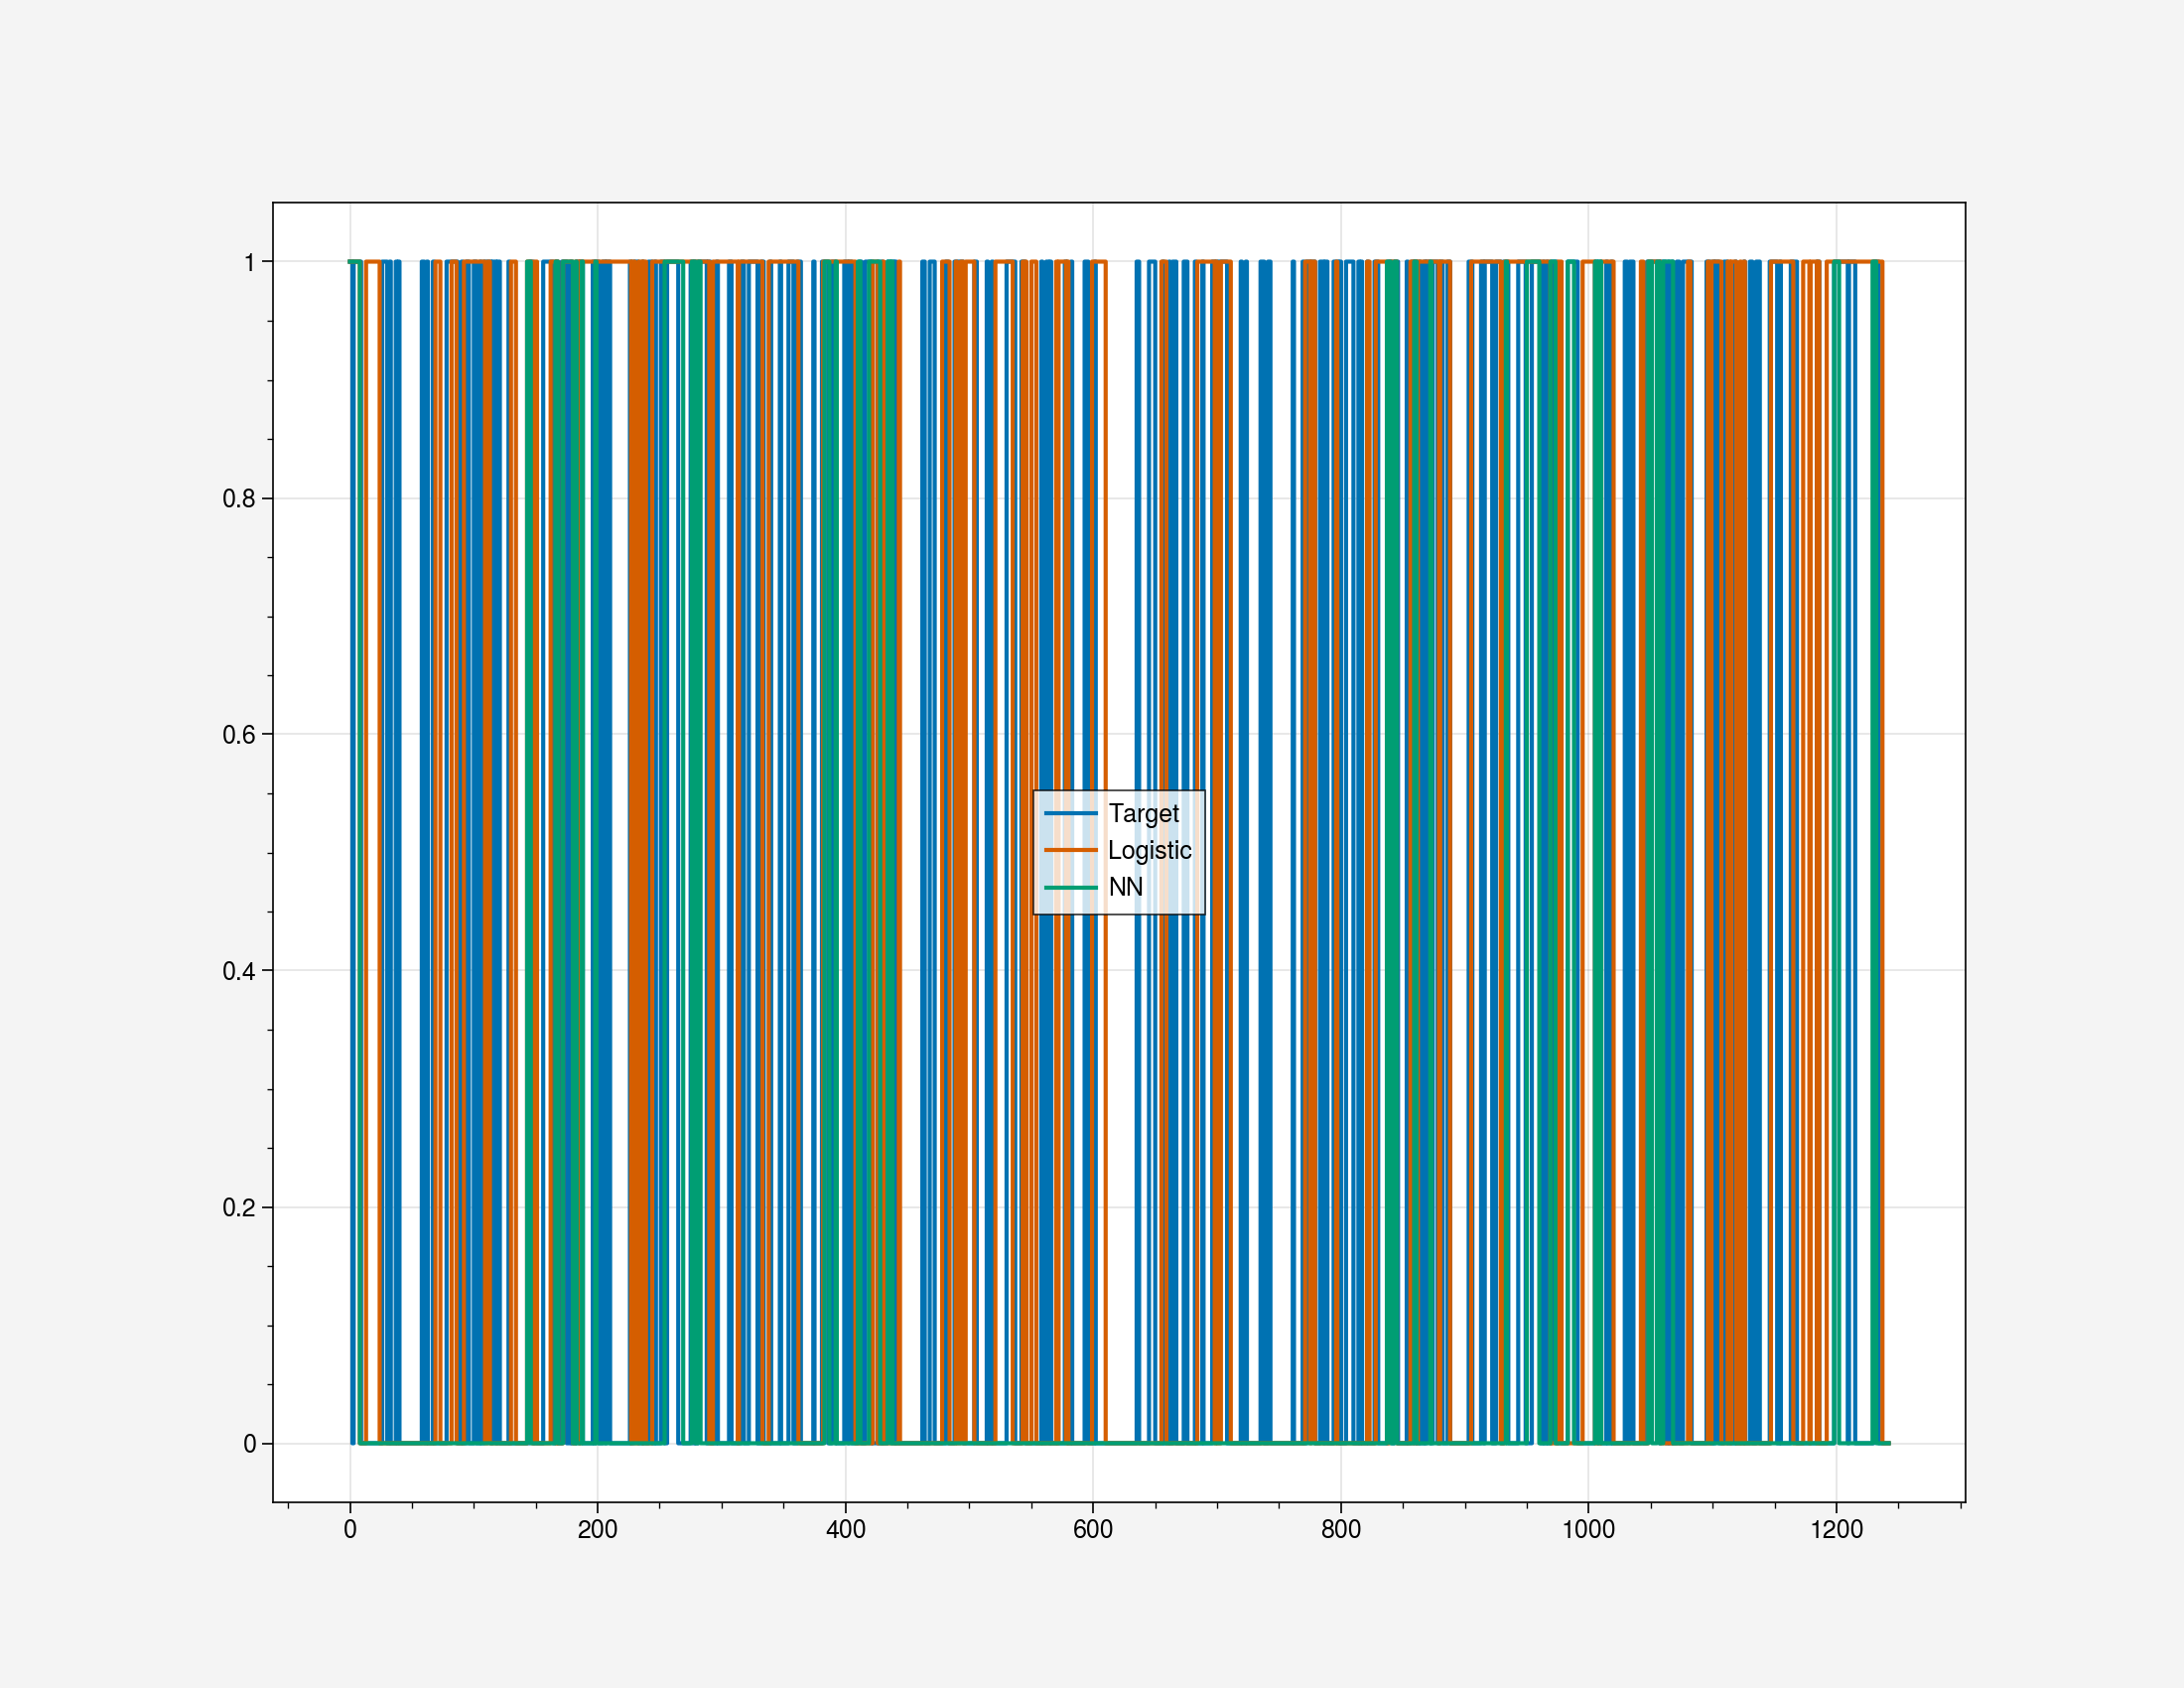

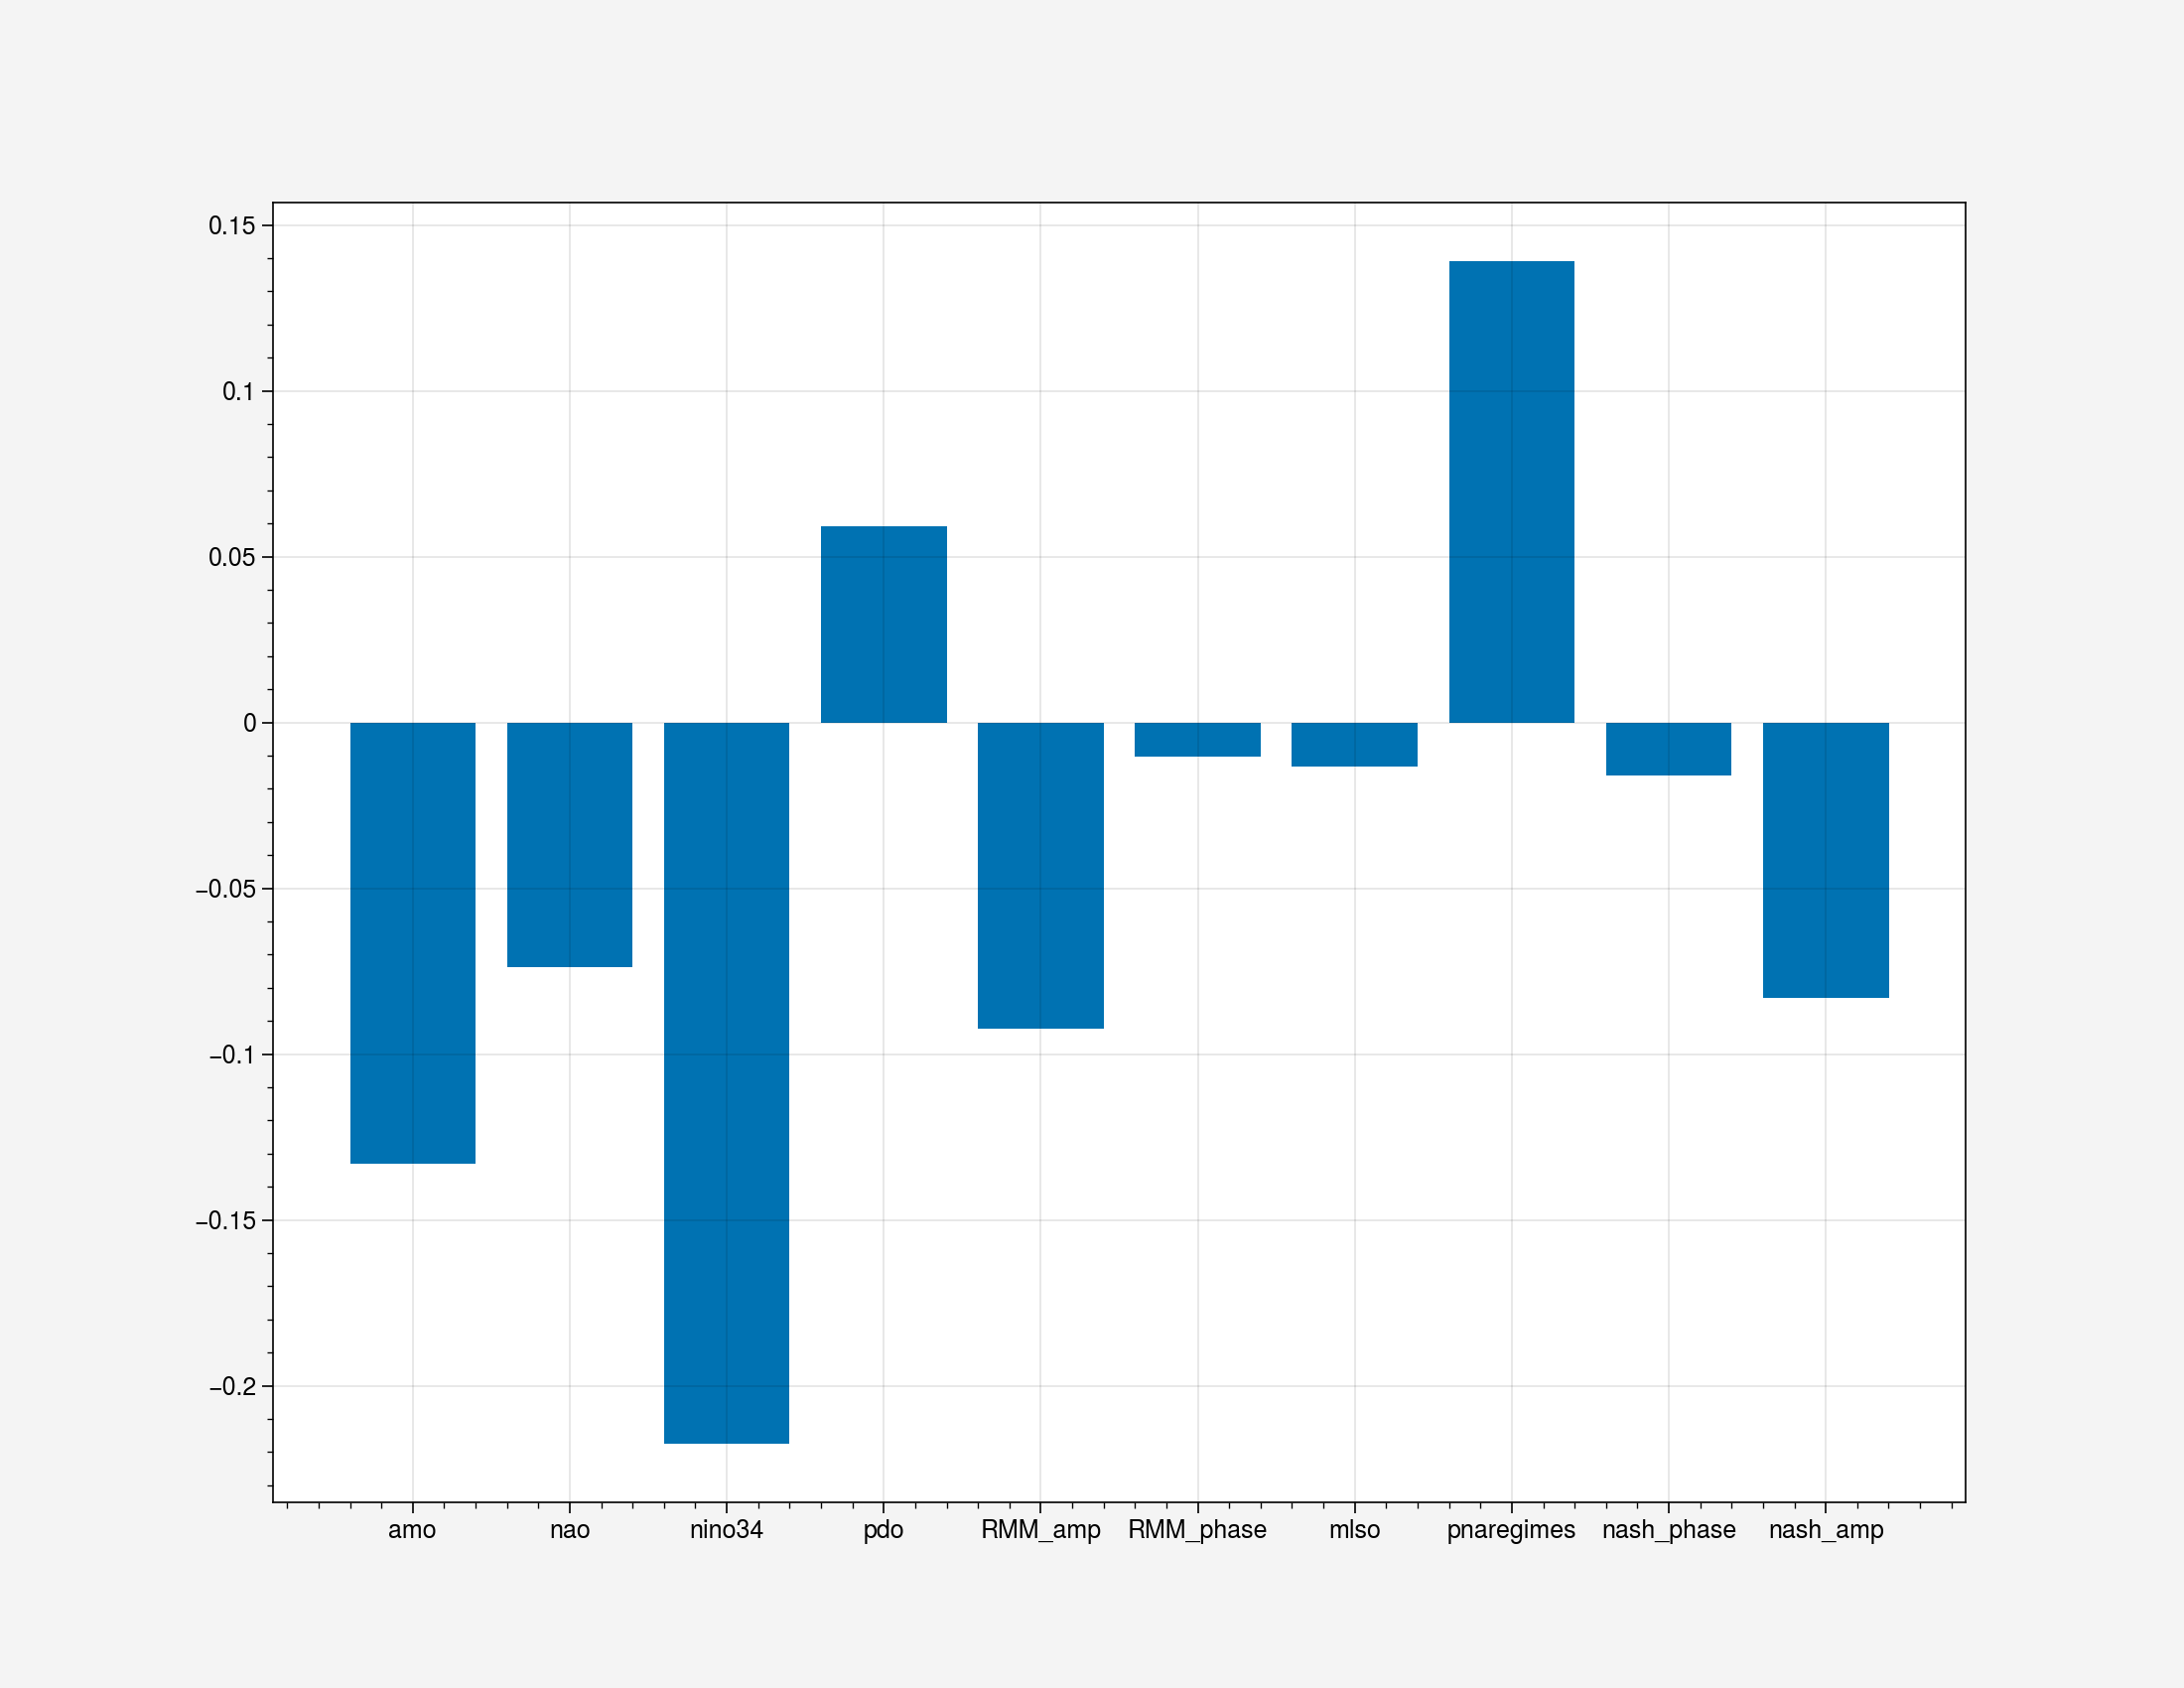

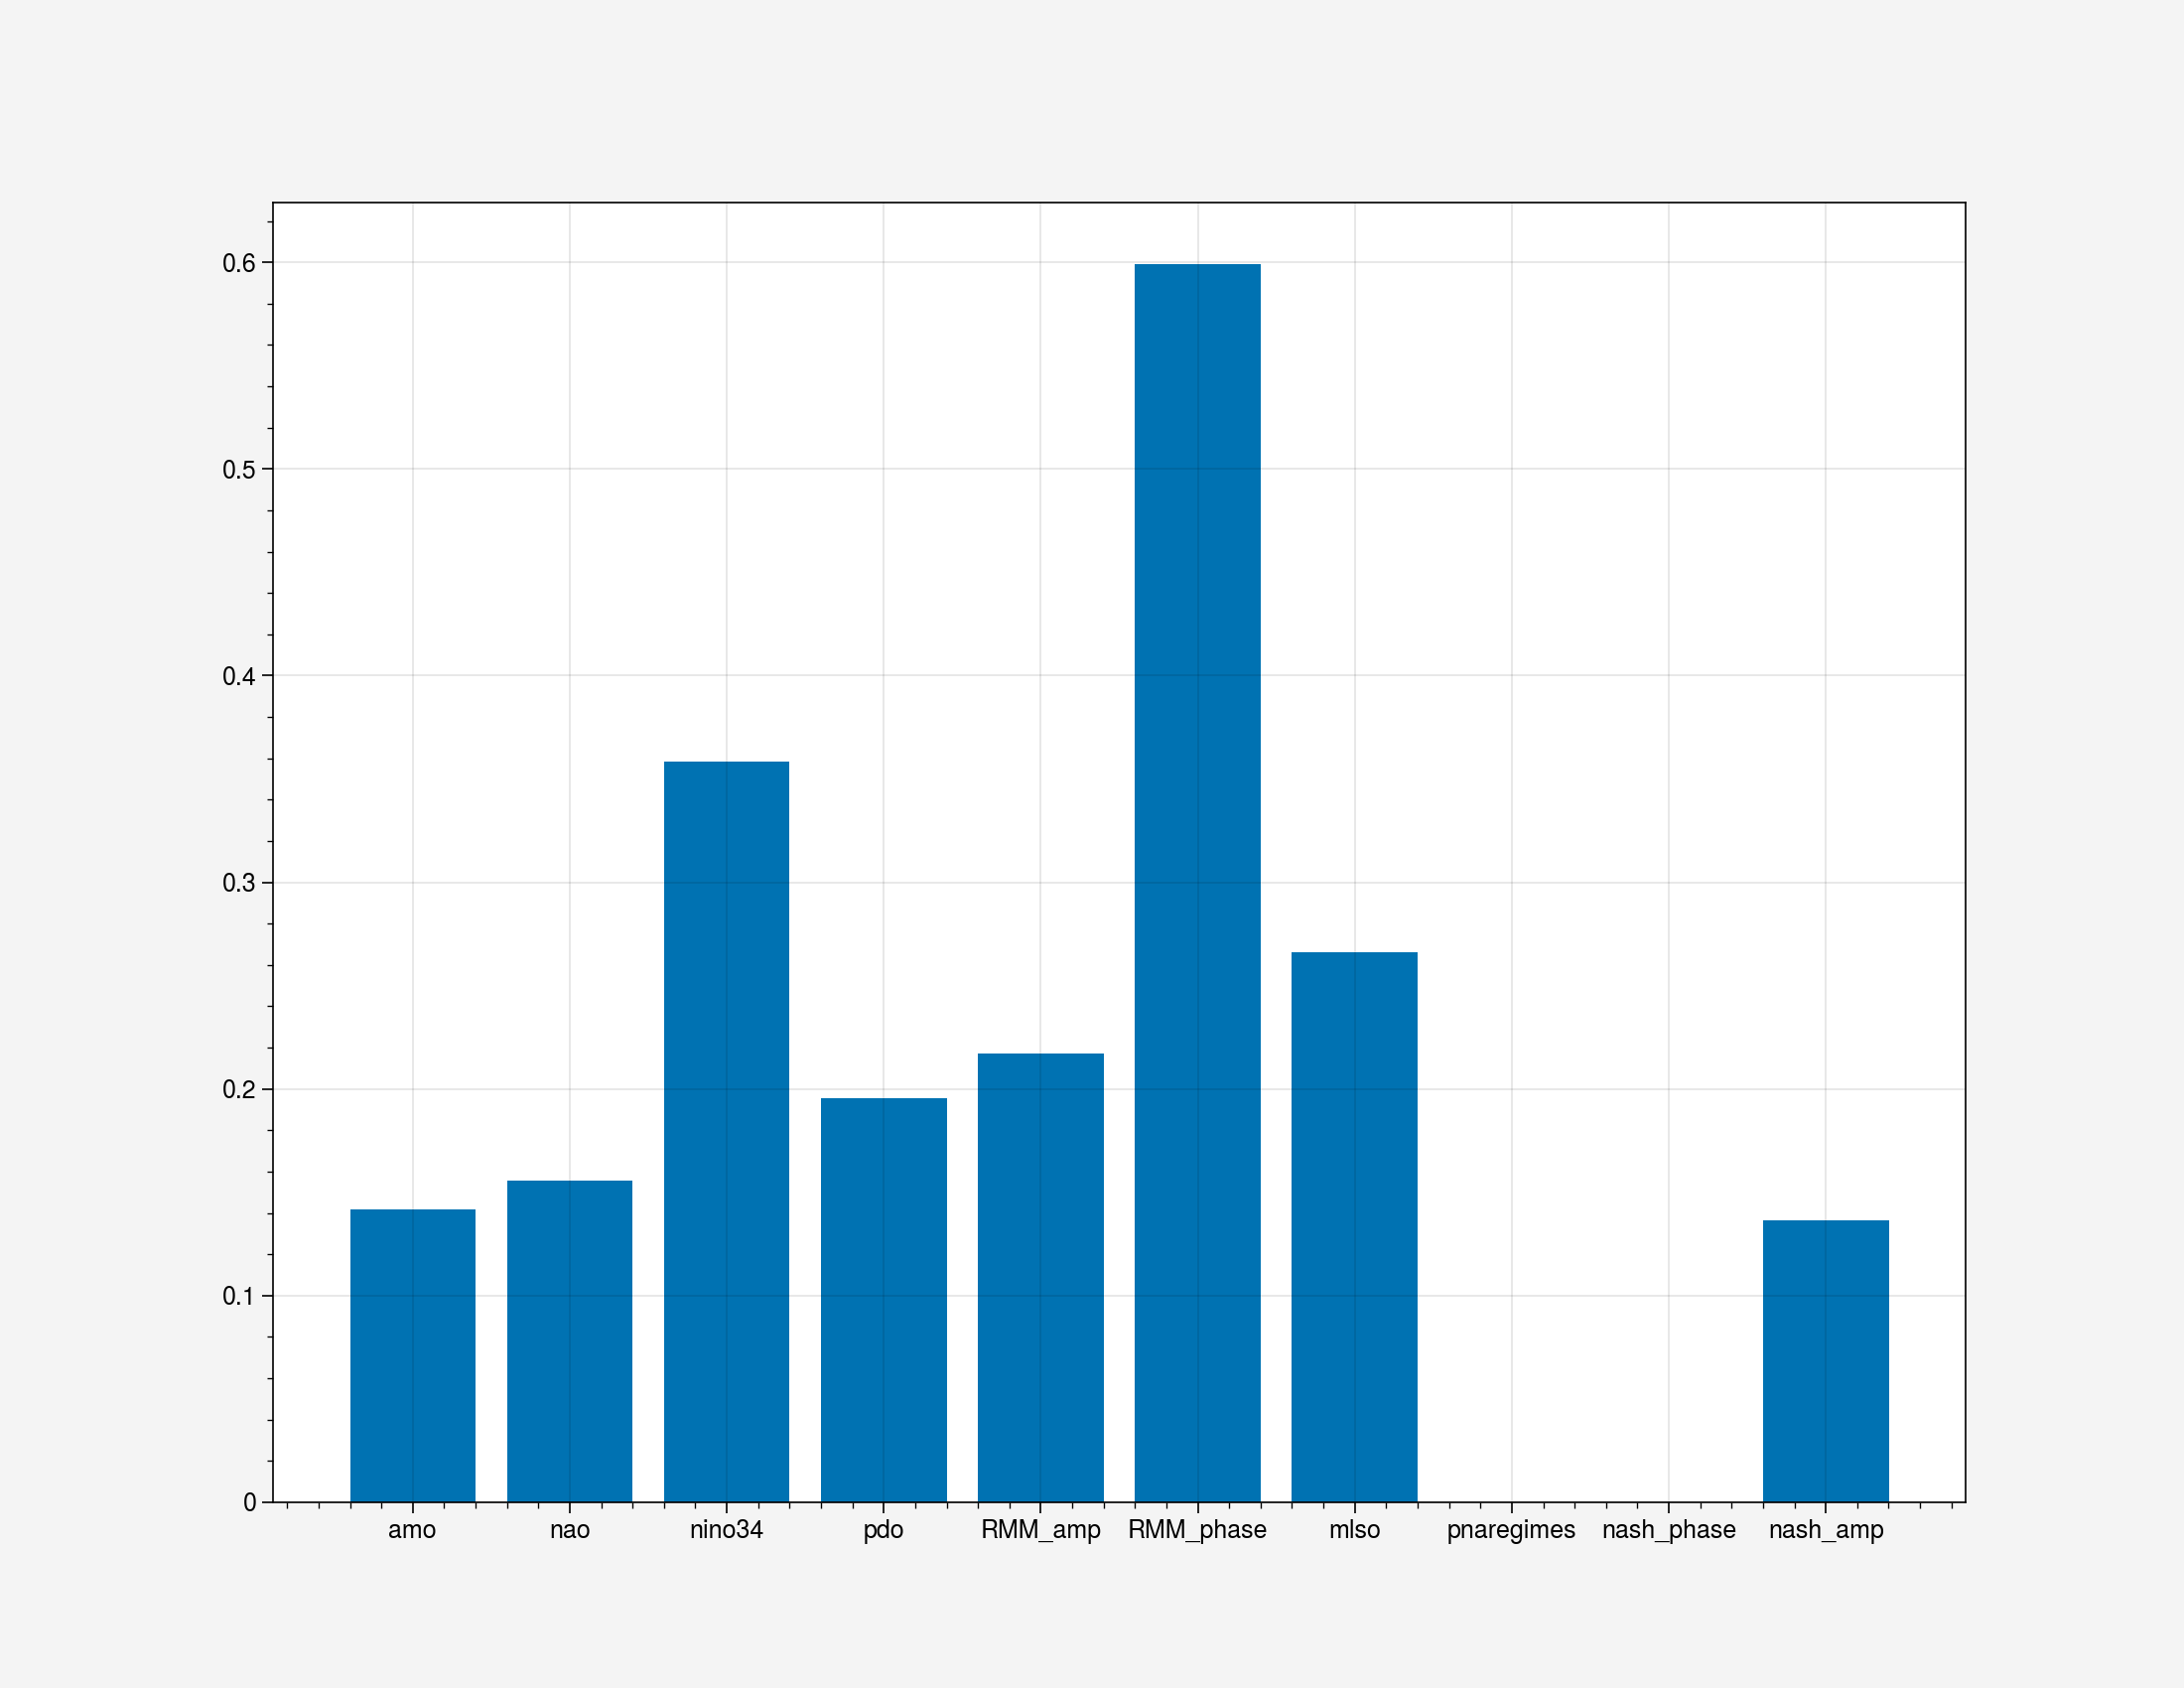

In [5]:
indices_dict=init_predictors_dict()

# Loop over seasons
for seas,slabel,seas_abbrv in zip([summer],['Summer'],['JJA']):
#for seas,slabel,seas_abbrv in zip([winter,summer],['Winter','Summer'],['DJF','JJA']):
    print(slabel)
        
    features_list=[]
    
    # Loop over all indices
    for i,f in enumerate(indices_dict):

        # Read the Indices
        if (f['ptype']=='index' and f['freq']=='mon'):
            ds=getattr(mlprecip_utils,f['readfunc'])(f['file'],f['name'],sdate,edate)
            # Linearly interpolate monthly indices to daily
            ds=ds.resample(time='1D').interpolate("linear").sel(time=slice(sdate,edate))
        elif (f['name']=='RMM_amp'):
            _,ds=getattr(mlprecip_utils,f['readfunc'])(f['file'],sdate,edate)
        elif (f['name']=='RMM_phase'):
            ds,_=getattr(mlprecip_utils,f['readfunc'])(f['file'],sdate,edate)
        elif (f['name']=='pnaregimes'): 
            ds=getattr(mlprecip_utils,f['readfunc'])(f['file'],seas_abbrv,sdate,edate)
        elif (f['name']=='nash_amp'):
            _,ds=getattr(mlprecip_utils,f['readfunc'])(f['file'],sdate,edate)
        elif (f['name']=='nash_phase'):
            ds,_=getattr(mlprecip_utils,f['readfunc'])(f['file'],sdate,edate)
        else:
            ds=getattr(mlprecip_utils,f['readfunc'])(f['file'],sdate,edate)
   
        # Detrend and standardize indices that are not categorical
        if (f['ptype']=='index'):
            v=f['name']
            detrend=signal.detrend(ds[v],axis=0,type='linear')     
            ds[v]=xr.DataArray(detrend,coords={'time': ds['time'].values},dims=['time'])     
            ds[v]=(ds[v]-ds[v].mean(dim='time'))/ds[v].std(dim='time')
        
        # Select season from predictor index and target index
        ds_i=ds.sel(time=ds['time.month'].isin(seas)) #.dropna(dim='time')        
        ds_p=ds_anoms.sel(time=ds_anoms['time.month'].isin(seas)).sel(time=slice(sdate,edate)) #.dropna(dim='time')
        
        # Append this predictor index to list of all predictors
        features_list.append(ds_i[f['name']])

        # Categorize predictor indices for composites and ratios
        ds_bins=[]
        if (f['ptype']=='index'):
            ds_bins=makeCategories(ds_i,bins,f['name'])
            labels=['Positive','Neutral','Negative']
        else:
            ds_bins=xr.DataArray(ds[f['name']],
                                 coords={'time':ds['time'].values},
                                 dims=['time'])  
            ds_bins=ds_bins.to_dataset(name=f['name']+'_bins')
            nbins=int(np.nanmax(ds[f['name']].values)+1)
            labels=np.arange(nbins).astype(str)  
        ds=xr.merge([ds_p,ds_bins])
        
        #---------- COMPOSITES ------------#
        ds_comp,totals=calcComposites(ds,f['name'],labels)
        ds_totals=xr.concat(totals,dim=f['name']+'_bins').to_dataset(name='bins_count')
        suptitle=slabel+' '+' Anomalies '+f['name'].upper()
        compfile='../figs/comp_anomaly.daily.'+slabel+'.'+f['name']+'.png'
        plotComposites(ds_comp,f['name'],totals,suptitle,labels,clevs,cmap,compfile)
        
        #---------- % DAYS ABOVE/BELOW NORMAL -------#   
        da_above,da_below,da_ratio=calcRatios(ds,f['name'],'precip',0.0)
        clevs_ratio=np.arange(0,100,5)
        
        # Above
        suptitle=f['name'].upper()+' % Days Above Normal '+slabel
        compfile='../figs/comp_above.daily.'+slabel+'.'+f['name']+'.png'
        plotRatios((da_above/(da_above+da_below)*100),f['name'],suptitle,labels,clevs_ratio,'Greens1',compfile)
        
        # Below
        suptitle=f['name'].upper()+' % Days Below Normal '+slabel
        compfile='../figs/comp_below.daily.'+slabel+'.'+f['name']+'.png'
        plotRatios((da_below/(da_above+da_below)*100),f['name'],suptitle,labels,clevs_ratio,'Browns3',compfile)
        
   
    #----- FIT MODELS AND TEST  -----------#

    # Define Features
    ds_features=xr.merge(features_list).dropna(dim='time')   
    
    # Define Index Target as Mean precip in region
    # Note this is currently designed as a diagnostic not a real prediction; add target lead for prediction
    ds_target=ds_p.mean(dim=['lat','lon'])
    
    # Make sure we have the same times for target and features
    ds_target,ds_features=xr.align(ds_target,ds_features,join='inner')
    
    # Test the prediction of daily preciptation anomaly
    print('============= Regression ==========================')
    testModelsRegr(ds_features,ds_target)
    
    # Test the prediction of precipitation in category defined by threshold
    print('============= Categorical upper tercile  ================')
    thresh=np.percentile(ds_target['precip'],66)
    print("Upper Tercile: ",thresh)
    testModelsCat(ds_features,xr.where(ds_target>thresh,1,0))
        
    print('============= Categorical lower tercile ===============')
    thresh=np.percentile(ds_target['precip'],33)
    print("Lower Tercile: ",thresh)
    testModelsCat(ds_features,xr.where(ds_target<thresh,1,0))